In [1]:
!nvidia-smi

Sun Sep  5 04:00:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/test.csv')

In [4]:
!mkdir images_train
!mkdir images_train/0
!mkdir images_train/1
!mkdir images_train/2
!mkdir images_train/3
!mkdir images_train/4
!mkdir images_train/5
!mkdir images_train/6
!mkdir images_train/7
!mkdir images_train/8
!mkdir images_train/9
!mkdir images_test

In [5]:
import cv2

for idx in range(len(train)) :
    img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
    digit = train.loc[idx, 'digit']
    cv2.imwrite(f'./images_train/{digit}/{train["id"][idx]}.png', img)

In [6]:
import cv2

for idx in range(len(test)) :
    img = test.loc[idx, '0':].values.reshape(28, 28).astype(int)
    cv2.imwrite(f'./images_test/{test["id"][idx]}.png', img)

In [7]:
import tensorflow as tf
DenseNet121_model = tf.keras.applications.DenseNet121(weights=None, include_top=True, input_shape=(224, 224, 1), classes=10)

In [8]:
from tensorflow.keras.optimizers import Adam
DenseNet121_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.002,epsilon=None), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                             rescale=1./255, 
                             validation_split=0.2,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

batch_size = 32
train_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), batch_size = batch_size, color_mode='grayscale', class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), batch_size = batch_size,  color_mode='grayscale', class_mode='categorical', subset='validation')

Found 1642 images belonging to 10 classes.
Found 406 images belonging to 10 classes.


In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/DACON_CVLC/Checkpoint/BS_32_1_DN121.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [11]:
DenseNet121_model.fit_generator(train_generator, epochs = 500, validation_data = val_generator, callbacks = [checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
52/52 [==============================] - 53s 471ms/step - loss: 1.9066 - accuracy: 0.3374 - val_loss: 17.7879 - val_accuracy: 0.1010

Epoch 00001: val_accuracy improved from -inf to 0.10099, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/BS_32_1_DN121.h5
Epoch 2/500
52/52 [==============================] - 19s 368ms/step - loss: 1.1862 - accuracy: 0.5974 - val_loss: 4.8444 - val_accuracy: 0.1010

Epoch 00002: val_accuracy did not improve from 0.10099
Epoch 3/500
52/52 [==============================] - 19s 369ms/step - loss: 1.0072 - accuracy: 0.6681 - val_loss: 9.9821 - val_accuracy: 0.1010

Epoch 00003: val_accuracy did not improve from 0.10099
Epoch 4/500
52/52 [==============================] - 19s 372ms/step - loss: 0.8067 - accuracy: 0.7205 - val_loss: 50.8979 - val_accuracy: 0.1034

Epoch 00004: val_accuracy improved from 0.10099 to 0.10345, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/BS_32_1_DN121.h5
Epoch 5/500
52/52 [================

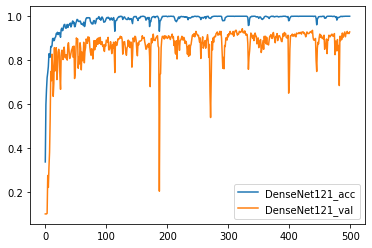

In [12]:
import matplotlib.pyplot as plt

plt.plot(DenseNet121_model.history.history["accuracy"], label='DenseNet121_acc')
plt.plot(DenseNet121_model.history.history["val_accuracy"], label='DenseNet121_val')

plt.legend()
plt.show()

In [13]:
DenseNet121_model = tf.keras.models.load_model('/content/drive/MyDrive/DACON_CVLC/Checkpoint/BS_32_1_DN121.h5', compile=False)

In [14]:
!mkdir images_test/none
!mv images_test/*.png images_test/none

In [15]:
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory('./images_test', target_size=(224,224), color_mode='grayscale', class_mode='categorical', shuffle=False)

Found 20480 images belonging to 1 classes.


In [16]:
DenseNet121_predict = DenseNet121_model.predict_generator(test_generator).argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [17]:
submission = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/submission.csv')

In [18]:
import numpy as np
mylist = []

for i in range(len(submission)):
    name =  test_generator.filenames
    id = name[i].split('/')[1].rstrip('.').split('.')[0]
    mylist.append(id)

In [19]:
for i in range(len(submission)):
    submission["id"][i] = mylist[i]

In [20]:
submission["DenseNet121_predict"] = DenseNet121_predict

In [21]:
from collections import Counter

for i in range(len(submission)) :
    predicts = submission.loc[i, ['DenseNet121_predict']]
    submission.at[i, "digit"] = Counter(predicts).most_common(n=1)[0][0]

In [22]:
submission = submission[['id', 'digit']]
submission.head()

,id,digit
0,10000,4
1,10001,4
2,10002,6
3,10003,9
4,10004,5


In [23]:
from google.colab import files

submission.to_csv('/content/drive/MyDrive/DACON_CVLC/Submission/BatchSize_32_1_DenseNet121_model.csv', index=False)
files.download('/content/drive/MyDrive/DACON_CVLC/Submission/BatchSize_32_1_DenseNet121_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>